In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy.io import loadmat #load mat data on python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

In [2]:
def encoderextract2D(x_train):

    ## define the encoder
    encoder = Input(shape=(x_train.shape[1], x_train.shape[2],x_train.shape[3]))
    e = Conv2D(filters=128, kernel_size=(5,5), padding="same", strides=7, activation="relu")(encoder)
    e = Conv2D(filters=64, kernel_size=(5,5), padding="same", strides=3, activation="relu")(e)
    e = Conv2D(filters=16, kernel_size=(5,5), padding="same", strides=1, activation="relu")(e)
    ## bottleneck layer
    n_bottleneck = 8
    ## defining it with a name to extract it later
    bottleneck_layer = "bottleneck_layer"
    # can also be defined with an activation function, relu for instance
    bottleneck = Dense(n_bottleneck, name=bottleneck_layer)(e)

    ## define the decoder (in reverse)
    decoder = Conv2DTranspose(filters=4, kernel_size=(5,5), padding="same", strides=3, activation="relu")(bottleneck)
    #decoder = Conv2DTranspose(filters=2, kernel_size=(5,5), padding="same", strides=3, activation="relu")(decoder)
    decoder = Conv2DTranspose(filters=2, kernel_size=(5,5), padding="same", strides=7, activation="relu")(decoder)
    ## output layer
    output = Conv2DTranspose(filters=1, kernel_size=(5,5), padding="same")(decoder)
    ## model
    model = Model(inputs=encoder, outputs=output)
    encoder = Model(inputs=model.input, outputs=bottleneck)
    model.summary()
    model.compile(loss="mse", optimizer="adam")
    history = model.fit(
    x_train,
    x_train,
    batch_size = 4,
    epochs = 100,
    verbose = 1,
    validation_split=0.25
    )
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()
    bottneck = encoder.predict(x_train)
    #out = np.reshape(bottneck,(-1,bottneck[2]))
   #out = out.T
    #bottneck.to_csv(r"bottneck.csv",mode = 'a',index =False)
    return bottneck

def standard(data):
    meansdata = np.mean(data)
    stddata = np.std(data)
    if stddata !=0:
        standdata = (data - meansdata) / stddata
    else: 
        standdata = data
    #normaldata = normaldata.reshape((normaldata.shape[0], normaldata.shape[1], 1))
    return standdata
def normal(data):
    _range = np.max(data) - np.min(data)
    if _range !=0:
        normaldata = (data - np.min(data)) / _range
    else:
        normaldata = data
    return normaldata

In [3]:
samplepointcolumn = np.linspace(0,105,105,endpoint=False,dtype=int)
discardall =[] 
for j in range(0,7):
    discard = [j*15+3,j*15+4,j*15+5,j*15+6,j*15+7,j*15+8]#j*15+9,j*15+10,j*15+11,j*15+12,j*15+13,j*15+14
    discardall = discardall+discard
samplepointcolumn = np.delete(samplepointcolumn,discardall)

In [4]:
TrainData = np.load( "/Users/ycs/Desktop/PhD first year/Fall2021 Task 1/lulu code and data/PVfarm data/PMUalldatanpz.npz" )
x_train = np.zeros((44,63,126))
X_train = np.zeros((44,63,126))
j=0
discardcase = [3, 7, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
for i in range(1,63):
    if i in discardcase:
        continue
    Traindata = TrainData['a'][i,:,:]
    #traindata = Traindata.values[0:105,600:720]
    traindata = Traindata[samplepointcolumn,600:726]
    train = np.zeros((traindata.shape[0],traindata.shape[1]))
    for k in range(0,traindata.shape[0]):
        train[k,:] = standard(traindata[k,:])
        train[k,:] = normal(train[k,:])
    #train = standard(traindata)
    x_train[j,:,:] = train
    j+=1

In [5]:
for j in range(44):
    for jj in range(7):
        if (sum(x_train[j,2+jj*9,:])>=100):
           #print(j,jj)
            x_train[j,(2):]=1
            x_train[j,(11):]=1
            x_train[j,(20):]=1
            x_train[j,(29):]=1
            x_train[j,(38):]=1
            x_train[j,(47):]=1
            x_train[j,(56):]=1
        else:
            x_train[j,2+jj*9,:]=0

2021-11-12 16:30:11.847952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 16:30:11.982937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63, 126, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 18, 128)        3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 6, 64)          204864    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 6, 16)          25616     
_________________________________________________________________
bottleneck_layer (Dense)     (None, 3, 6, 8)           136       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 18, 4)          804       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 63, 126, 2)        202   

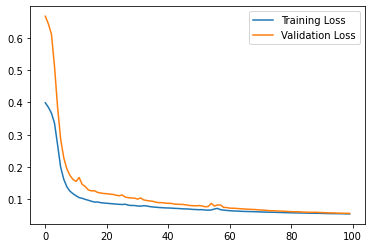

In [8]:
x_train2 = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
bott_neck2D = encoderextract2D(x_train2)

In [17]:
bott_neck2D.shape

(44, 3, 6, 8)

In [21]:
bott_neck2 = np.reshape(bott_neck2D,(44,-1))

In [30]:
svd=np.zeros((44,18))
for i in range(0,44):
    for j in range(0,3):
        U,svd[i,j*6:j*6+6],V = np.linalg.svd(bott_neck2D[i,j,:,:]) 

In [31]:
from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters = 3, random_state = 13).fit_predict(svd)
kmeans3

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1],
      dtype=int32)